/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.1103 - val_loss: 4.2003e-04
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 5.2829e-04 - val_loss: 1.0078e-04
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.3447e-05 - val_loss: 2.5276e-04
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.8768e-05 - val_loss: 3.7933e-04
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.5848e-05 - val_loss: 9.0756e-05
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7930e-05 - val_loss: 2.5991e-04
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0333e-05 - val_loss: 2.7674e-04
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4486e-05 - val_loss: 2.8492e-04
Epoch 9/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1614e-05 - val_loss: 2.4593e-04
Epoch 10/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1502e-05 - val_loss: 3.1404e-04
Epoch 11/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4469e-05 - 

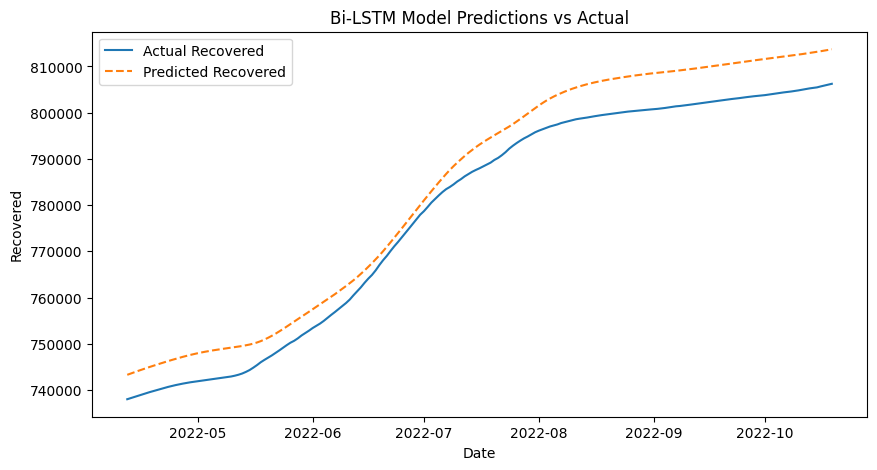

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


df = pd.read_csv("SaudiNov2022data.csv")
df = df.iloc[:, [0, 4]]
df.columns = ["Date", "Recovered"]
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)


scaler = MinMaxScaler(feature_range=(0, 1))
df["Recovered"] = scaler.fit_transform(df[["Recovered"]])


def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 10
data = df["Recovered"].values
X, y = create_sequences(data, SEQ_LENGTH)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, activation='relu'), input_shape=(SEQ_LENGTH, 1)),
    Bidirectional(LSTM(50, activation='relu')),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2)


loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


predictions = model.predict(X_test)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
predictions_inv = scaler.inverse_transform(predictions)


mse = mean_squared_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Actual Recovered")
plt.plot(df.index[-len(predictions):], predictions_inv, label="Predicted Recovered", linestyle='--')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Recovered")
plt.title("Bi-LSTM Model Predictions vs Actual")
plt.savefig("Bi-LSTM_Recovered.pdf", format="pdf", bbox_inches="tight")
plt.show()